### CNN Architecture

| Layer             | Filters | Kernel Size | Activation | Padding | Pool Size | Output Shape |
|-------------------|---------|-------------|------------|---------|-----------|--------------|
| Input             | -       | -           | -          | -       | -         | (Input Length, 1) |
| Conv1D            | 32      | 3           | relu       | same    | -         | (Input Length, 32) |
| MaxPooling1D      | -       | -           | -          | -       | 2         | (Input Length/2, 32) |
| Conv1D            | 64      | 3           | relu       | same    | -         | (Input Length/2, 64) |
| MaxPooling1D      | -       | -           | -          | -         | 5         | (Input Length/10, 64) |
| Conv1D            | 128     | 3           | relu       | same    | -         | (Input Length/10, 128) |
| MaxPooling1D      | -       | -           | -          | -         | 5         | (Input Length/50, 128) |
| Conv1D            | 256     | 3           | relu       | same    | -         | (Input Length/50, 256) |
| MaxPooling1D      | -       | -           | -          | -         | 5         | (Input Length/250, 256) |
| Flatten           | -       | -           | -          | -         | -         | (approx. Input Length/250 * 256) |
| Dense             | 2048    | -           | relu       | -         | -         | (2048,) |
| Dense             | 100     | -           | relu       | -         | -         | (100,) |
| Dense             | 3       | -           | linear     | -         | -         | (3,) |

*Note: The output shapes are approximate and depend on the input length and padding.*

In [1]:
# ====== Imports ======
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import iqr

In [2]:
# ====== Device ======
device_name = tf.test.gpu_device_name()
if device_name:
    print("Using GPU:", device_name)
else:
    print("Using CPU")

Using GPU: /device:GPU:0


In [3]:
# ==================== Load Data ====================
file_path = '/content/spectra_train_795.csv'
X_df = pd.read_csv(file_path)
print("df shape:", X_df.shape)

y_df = pd.read_csv("/content/target_train_795.csv")
print("y shape:", y_df.shape)

concen_columns = ['Moi','NDF','Starch']

df shape: (795, 257)
y shape: (795, 3)


In [4]:
# ====== Scaling ======
def autoscale(X):
    """Autoscale (mean centering + unit variance)."""
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std[std == 0] = 1e-8
    return (X - mean) / std

X_scaled = autoscale(X_df.values)
y_scaled = autoscale(y_df.values)

# Add channel dimension for CNN
X = np.expand_dims(X_scaled, axis=2)  # shape: [N, L, 1]
y = y_scaled  # shape: [N, num_targets]

# ====== Check input length ======
input_length = X.shape[1]
print("Input length:", input_length)

Input length: 257


In [46]:
# ====== Hyperparameters ======
batch_size = 50
epochs = 200
learning_rate = 0.001
n_splits = 5

In [47]:
# ====== Model definition ======
def build_model(input_length, num_classes=3):
    model = models.Sequential([
        layers.Input(shape=(input_length, 1)),

        layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=5),

        layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=5),

        layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=5),

        layers.Flatten(),

        layers.Dense(2048, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(num_classes, activation='linear')
    ])

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [48]:
# ====== Train/Test Split ======
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
print("Training+CV samples:", X_train_val.shape[0])
print("Test samples:", X_test.shape[0])

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_results = []
calibration_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
    print(f"\n=== Fold {fold+1} Training ===")

    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    model = build_model(input_length, num_classes=y.shape[1])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    # -------- Validation --------
    y_pred_val = model.predict(X_val)
    fold_rmse, fold_r2, fold_rpiq = [], [], []
    # print(f"\n=== Fold {fold+1} Validation Metrics ===") # Removed print
    for i, col in enumerate(concen_columns):
        rmse = np.sqrt(mean_squared_error(y_val[:, i], y_pred_val[:, i]))
        r2 = r2_score(y_val[:, i], y_pred_val[:, i])
        rpiq = iqr(y_val[:, i]) / rmse if rmse != 0 else np.inf
        fold_rmse.append(rmse)
        fold_r2.append(r2)
        fold_rpiq.append(rpiq)
        # print(f"{col}: RMSE={rmse:.4f}, R²={r2:.4f}, RPIQ={rpiq:.4f}") # Removed print

    fold_results.append((fold_rmse, fold_r2, fold_rpiq))

    # -------- Calibration Metrics (Training Data) --------
    y_pred_train = model.predict(X_train)
    cal_rmse, cal_r2, cal_bias = [], [], []
    # print(f"\n=== Fold {fold+1} Calibration Metrics ===") # Removed print
    for i, col in enumerate(concen_columns):
        rmse = np.sqrt(mean_squared_error(y_train[:, i], y_pred_train[:, i]))
        r2 = r2_score(y_train[:, i], y_pred_train[:, i])
        bias = np.mean(y_pred_train[:, i] - y_train[:, i])
        cal_rmse.append(rmse)
        cal_r2.append(r2)
        cal_bias.append(bias)
        # print(f"{col}: RMSE={rmse:.4f}, R²={r2:.4f}, Bias={bias:.4f}") # Removed print

    calibration_results.append((cal_rmse, cal_r2, cal_bias))

Training+CV samples: 596
Test samples: 199

=== Fold 1 Training ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

=== Fold 2 Training ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

=== Fold 3 Training ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

=== Fold 4 Training ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

=== Fold 5 Training ===
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [49]:
# ====== Average Calibration Metrics ======
avg_rmse_cal = np.mean([r[0] for r in calibration_results], axis=0)
avg_r2_cal = np.mean([r[1] for r in calibration_results], axis=0)
avg_bias_cal = np.mean([r[2] for r in calibration_results], axis=0)

print("\n=== Average Calibration Metrics ===")
avg_calibration_metrics_df = pd.DataFrame({
    'Property': concen_columns,
    'R²': avg_r2_cal,
    'RMSE': avg_rmse_cal,
    'Bias': avg_bias_cal
})
display(avg_calibration_metrics_df)

# ====== Average CV Metrics ======
avg_rmse_cv = np.mean([r[0] for r in fold_results], axis=0)
avg_r2_cv = np.mean([r[1] for r in fold_results], axis=0)
avg_bias_cv = np.mean([np.mean(model.predict(X_val)[:, i] - y_val[:, i]) for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)) for i, col in enumerate(concen_columns)], axis=0) # Calculate average bias for CV

print("\n=== Average CV Metrics ===")
avg_cv_metrics_df = pd.DataFrame({
    'Property': concen_columns,
    'R²': avg_r2_cv,
    'RMSE': avg_rmse_cv,
    'Bias': avg_bias_cv
})
display(avg_cv_metrics_df)


# ====== Evaluate on Test Set ======
y_test_pred = model.predict(X_test)
print("\n=== Test Set Metrics ===")
test_metrics = []
for i, col in enumerate(concen_columns):
    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_test_pred[:, i]))
    r2 = r2_score(y_test[:, i], y_test_pred[:, i])
    bias = np.mean(y_test_pred[:, i] - y_test[:, i])
    test_metrics.append({'Property': col, 'R²': r2, 'RMSE': rmse, 'Bias': bias})

test_metrics_df = pd.DataFrame(test_metrics)
display(test_metrics_df)


=== Average Calibration Metrics ===


,Property,R²,RMSE,Bias
0,Moi,0.982888,0.123741,0.035158
1,NDF,0.962959,0.189108,0.003732
2,Starch,0.972437,0.159185,-0.000794


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

=== Average CV Metrics ===


,Property,R²,RMSE,Bias
0,Moi,0.821057,0.400432,-0.007001
1,NDF,0.330707,0.798694,-0.007001
2,Starch,0.573554,0.628352,-0.007001


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

=== Test Set Metrics ===


,Property,R²,RMSE,Bias
0,Moi,0.874813,0.394967,0.068362
1,NDF,0.728279,0.534770,0.021429
2,Starch,0.793437,0.492594,-0.112394


In [50]:
print(f"\nAverage R² (Calibration): {avg_r2_cal.mean():.4f}")
print(f"Average R² (CV): {avg_r2_cv.mean():.4f}")
print(f"Average R² (Test): {r2_score(y_test.flatten(), y_test_pred.flatten()):.4f}") # Calculate overall R² for test set


Average R² (Calibration): 0.9728
Average R² (CV): 0.5751
Average R² (Test): 0.8034


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
=== Calibration Regression Plots ===


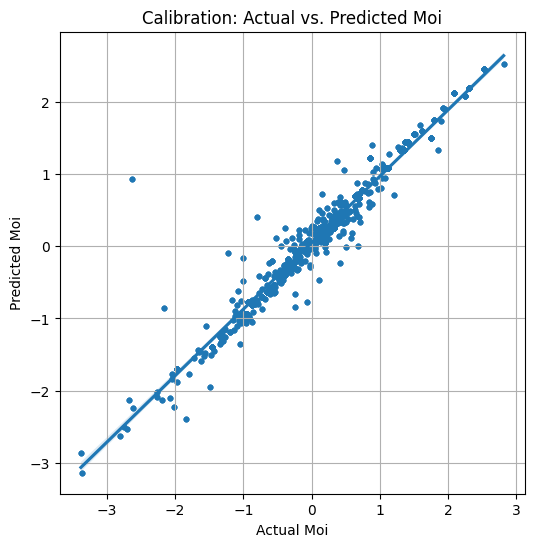

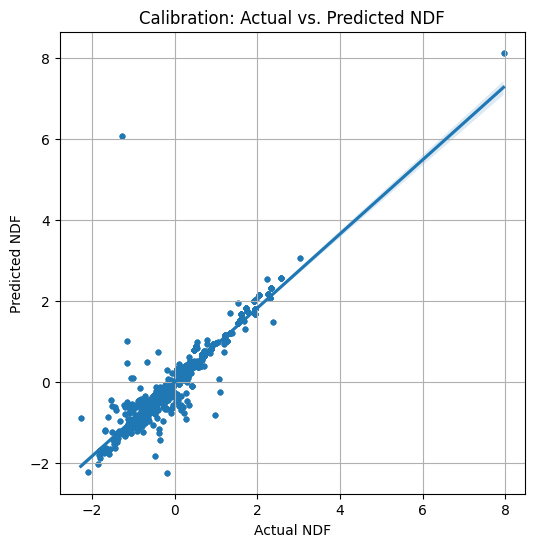

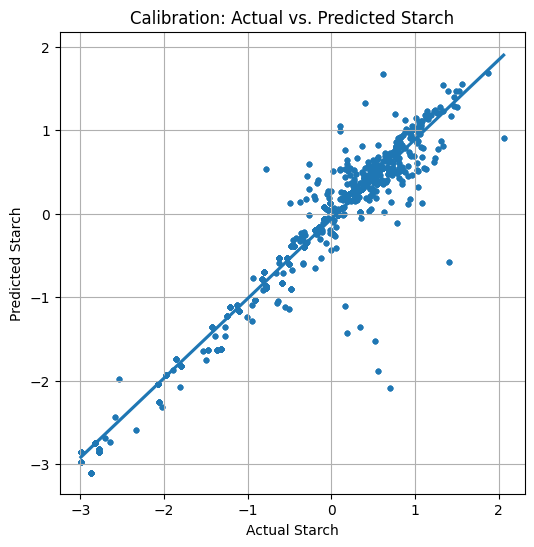

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create a directory to save plots if it doesn't exist
plots_dir = 'regression_plots'
os.makedirs(plots_dir, exist_ok=True)

# Combine predictions and actuals from all folds for calibration
y_train_combined = np.concatenate([y_train_val[train_idx] for train_idx, val_idx in kf.split(X_train_val)])
y_pred_train_combined = np.concatenate([model.predict(X_train_val[train_idx]) for train_idx, val_idx in kf.split(X_train_val)])

print("=== Calibration Regression Plots ===")
for i, col in enumerate(concen_columns):
    plt.figure(figsize=(6, 6))
    sns.regplot(x=y_train_combined[:, i], y=y_pred_train_combined[:, i], scatter_kws={'s': 10})
    plt.xlabel(f'Actual {col}')
    plt.ylabel(f'Predicted {col}')
    plt.title(f'Calibration: Actual vs. Predicted {col}')
    plt.grid(True)
    # Save the plot
    plot_filename = os.path.join(plots_dir, f'calibration_{col}_regression.png')
    plt.savefig(plot_filename)
    plt.show()


=== Test Set Regression Plots ===


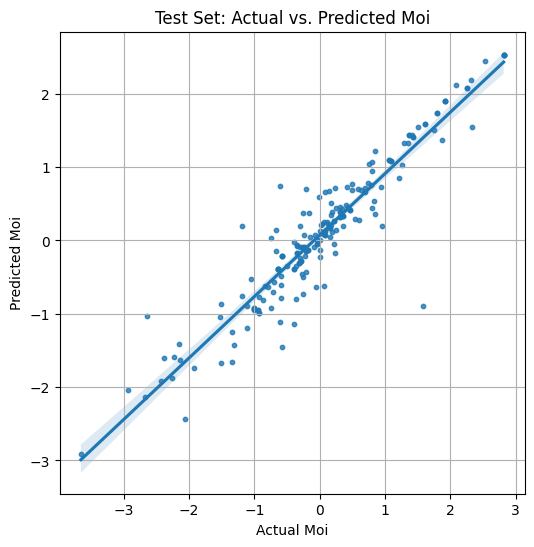

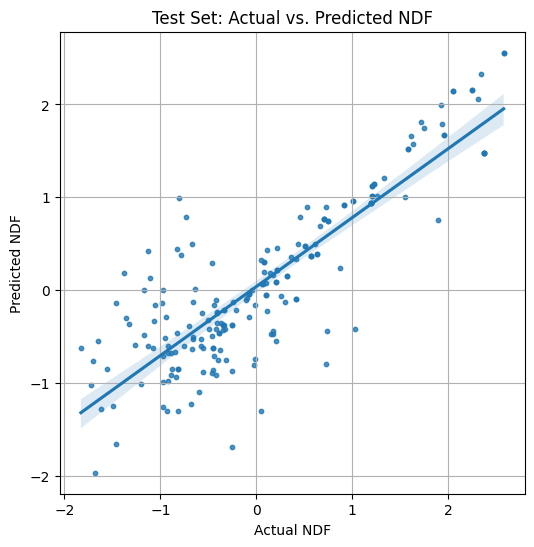

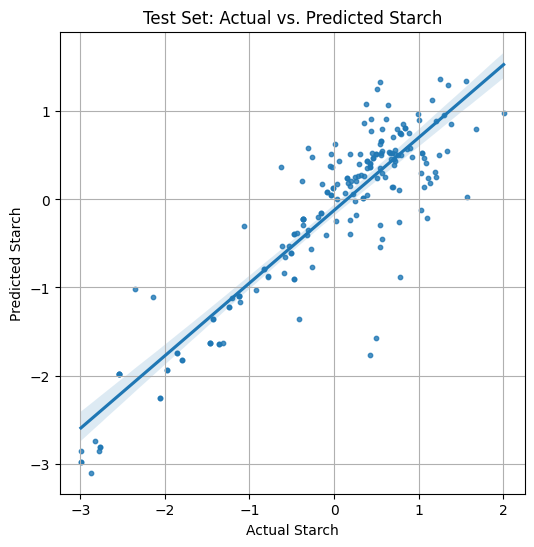

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create a directory to save plots if it doesn't exist
plots_dir = 'regression_plots'
os.makedirs(plots_dir, exist_ok=True)

print("\n=== Test Set Regression Plots ===")
for i, col in enumerate(concen_columns):
    plt.figure(figsize=(6, 6))
    sns.regplot(x=y_test[:, i], y=y_test_pred[:, i], scatter_kws={'s': 10})
    plt.xlabel(f'Actual {col}')
    plt.ylabel(f'Predicted {col}')
    plt.title(f'Test Set: Actual vs. Predicted {col}')
    plt.grid(True)
    # Save the plot
    plot_filename = os.path.join(plots_dir, f'test_{col}_regression.png')
    plt.savefig(plot_filename)
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== CV Regression Plots ===


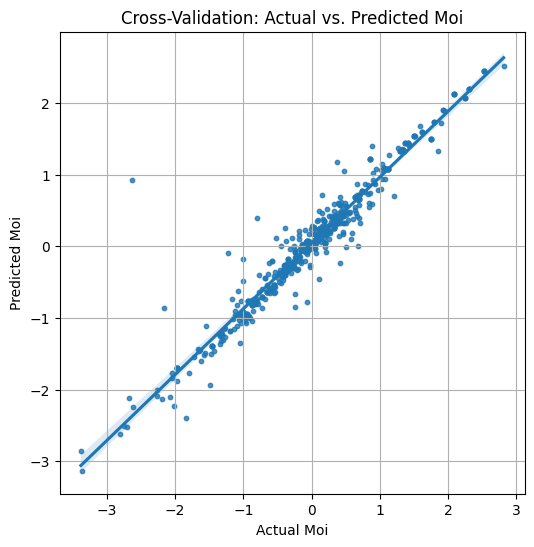

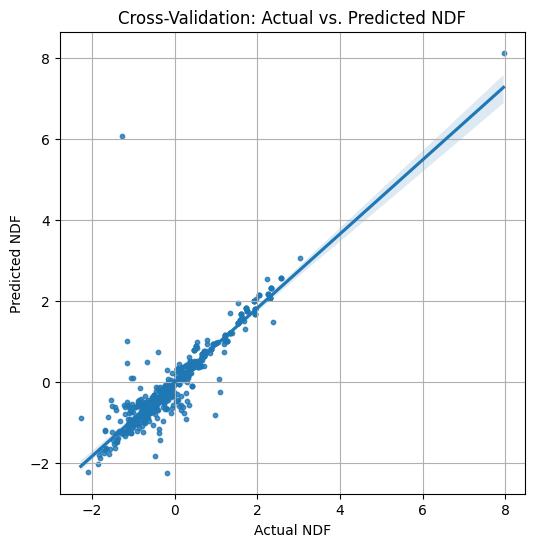

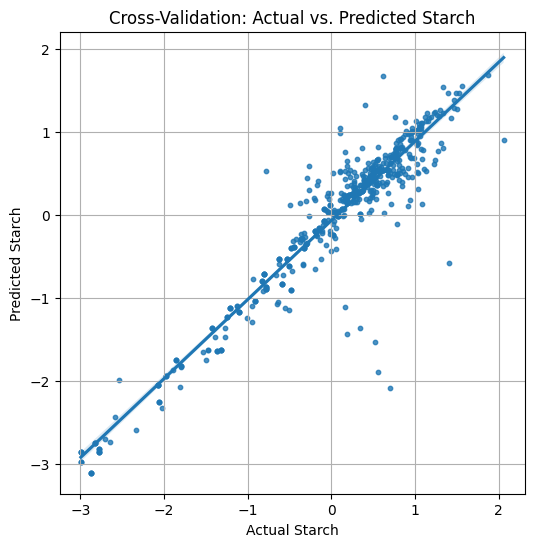

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create a directory to save plots if it doesn't exist
plots_dir = 'regression_plots'
os.makedirs(plots_dir, exist_ok=True)

# Combine predictions and actuals from all folds for CV
y_val_combined = np.concatenate([y_train_val[val_idx] for train_idx, val_idx in kf.split(X_train_val)])
y_pred_val_combined = np.concatenate([model.predict(X_train_val[val_idx]) for train_idx, val_idx in kf.split(X_train_val)])


print("\n=== CV Regression Plots ===")
for i, col in enumerate(concen_columns):
    plt.figure(figsize=(6, 6))
    sns.regplot(x=y_val_combined[:, i], y=y_pred_val_combined[:, i], scatter_kws={'s': 10})
    plt.xlabel(f'Actual {col}')
    plt.ylabel(f'Predicted {col}')
    plt.title(f'Cross-Validation: Actual vs. Predicted {col}')
    plt.grid(True)
    # Save the plot
    plot_filename = os.path.join(plots_dir, f'cv_{col}_regression.png')
    plt.savefig(plot_filename)
    plt.show()

In [58]:
from google.colab import files
import shutil

# Create a zip file of the plots folder
shutil.make_archive('regression_plots', 'zip', 'regression_plots')

# Download the zip file
files.download('regression_plots.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
# Save the trained model
model.save('simple_cnn_model.h5')
print("Model saved as simple_cnn_model.h5")

Model saved as simple_cnn_model.h5
